# Time Series Analysis: Champagne Sales

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests

In [3]:
# Loading the data
data = pd.read_csv('champagne.csv')

In [4]:
data

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0
...,...,...
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN


In [5]:
# Changing the column names 
data.columns = ['Date', 'Sales']

In [6]:
# Total missing values
data.isna().sum()

Date     1
Sales    2
dtype: int64

In [7]:
# Dropping missing values
data = data.dropna()

In [8]:
# Copying the data
df = data.copy()

It looks like we have got rid of missing values, however, we do not know if some values are skipped in the date column so we should set a frequency.

In [9]:
# Setting the date format
df['Date'] = pd.to_datetime(df.Date, dayfirst = True)

In [10]:
# Setting the date column as indices
df = df.set_index('Date')

In [11]:
# Setting monthly frequency with starting days
df = df.asfreq('MS')

In [12]:
# Total missing values
df.isna().sum()

Sales    0
dtype: int64

No missing data!

In [13]:
df.head()

,Sales
Date,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


### Plotting the Data

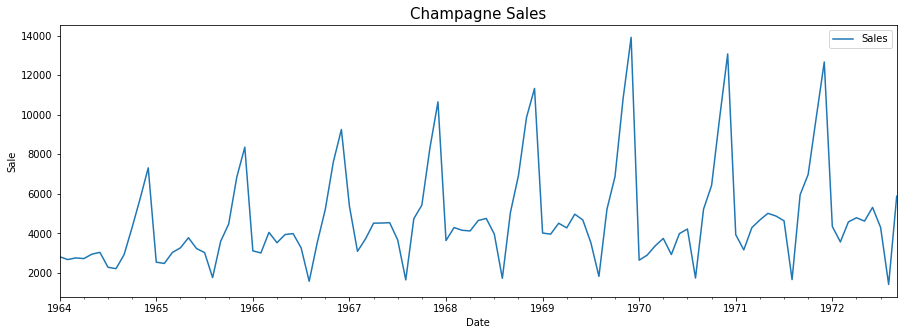

In [14]:
# Plotting the data
df.plot(figsize=(15,5))
plt.title("Champagne Sales", size = "15")
plt.xlabel("Date")
plt.ylabel("Sale")
plt.show()

# ARIMA Model

#### Test & Train Split

Let's set our last 12 months as our test set and the rest will become the train set.

In [15]:
# The size of the test set
n = 12
# Train and the test sets
train, test = df.iloc[:-n, :] , df.iloc[len(df)-n:, :]

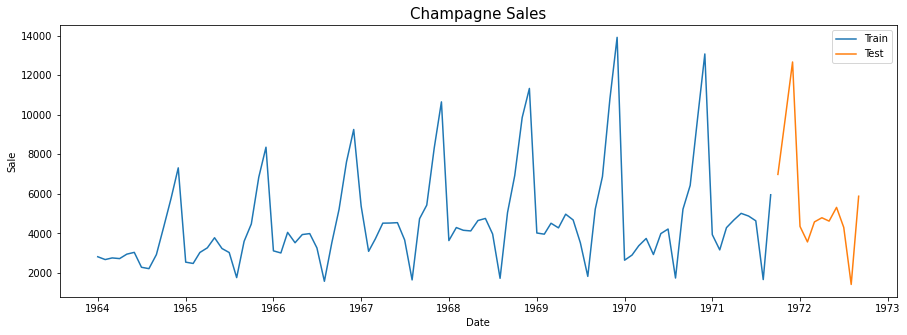

In [16]:
# Plotting the test and train data
plt.figure(figsize=(15,5))
plt.plot(train.index,train["Sales"], label = 'Train')
plt.plot(test.index,test["Sales"], label = 'Test')
plt.title("Champagne Sales", size = "15")
plt.xlabel("Date")
plt.ylabel("Sale")
plt.legend()
plt.show()

### ADF Test

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
# ADF Test
adf_test = adfuller(train["Sales"])

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.445970
p-value: 0.560050
Critical Values:
	1%: -3.514
	5%: -2.898
	10%: -2.586


The p-value is greater than 0.05 and ADF test statistics is also greater than all critical values.

Hence, the data is **not stationary**.

In [19]:
# Getting the first difference and removing the first column
first_diff = train.diff(1)
first_diff = first_diff[1:]

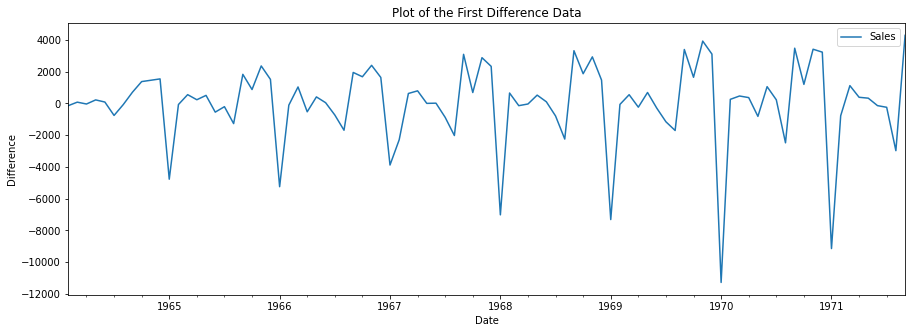

In [20]:
# Plot of the first difference
first_diff.plot(figsize=(15,5))
plt.title("Plot of the First Difference Data")
plt.xlabel("Date")
plt.ylabel("Difference")
plt.show()

In [21]:
# ADF test for the first difference
adf_test_diff1 = adfuller(first_diff)
print('1st Difference')
print('ADF Statistic: %f' % adf_test_diff1[0])
print('p-value: %f' % adf_test_diff1[1])
print('Critical Values:')
for key, value in adf_test_diff1[4].items():
    print('\t%s: %.3f' % (key, value))

1st Difference
ADF Statistic: -24.174014
p-value: 0.000000
Critical Values:
	1%: -3.514
	5%: -2.898
	10%: -2.586


The data is now **stationary**! 

d = 1 since it is integrated of order 1.

### Plotting ACF & PACF

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

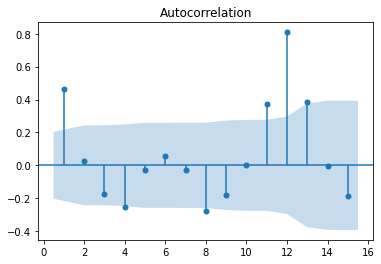

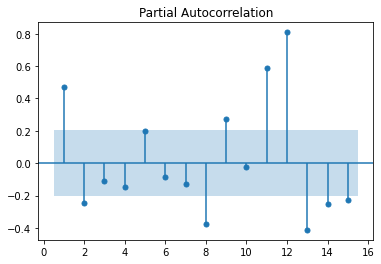

In [23]:
# ACF without 0-lag 
plot_acf(train["Sales"], lags=15, zero= False);   # Add ';'
                       # Otherwise it is plotted twice.
# PACF without 0-lag 
plot_pacf(train["Sales"], lags= 15, zero=False);  # Add ';'
                       # Otherwise it is plotted twice.


Considering the plots, some possible p and q parameters are :

p: 1,2

q: 1

### Seosanal Decomposition

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

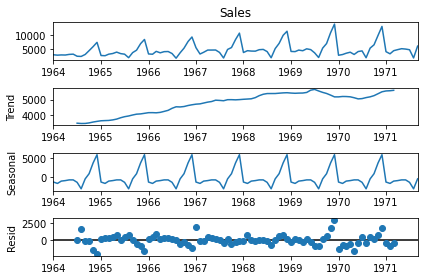

In [25]:
# Seosanal decomposition
decomposition = seasonal_decompose(train["Sales"], model ='additive')

# Making the plot 
decomposition.plot();  # Add ';'
                       # Otherwise it is plotted twice.

Considering the plots, there exists a seosanality and trend in the data. 

### Building the Model

We can try 2 possible SARIMA (p,d,q)(P,D,Q,m) models.

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [27]:
# SARIMAX (1,1,1)(1,1,1,12)
sarima_model_1 = SARIMAX(train['Sales'], order = (1,1,1), seasonal_order = (1,1,1,12))
sarima_model_1 = sarima_model_1.fit()
sarima_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   93
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -645.640
Date:                            Sun, 14 Mar 2021   AIC                           1301.280
Time:                                    15:37:41   BIC                           1313.190
Sample:                                01-01-1964   HQIC                          1306.055
                                     - 09-01-1971                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2985      0.090      3.304      0.001       0.121       0.476
ma.L1         -0.9465      0.049    -19.127      0.000      -1.043      -0.850
ar.S.L12      -0.6172      0.269     -2.294      0.022      -1.145      -0.090
ma.S.L12       0.3745      0.282      1.328      0.184      -0.178       0.927
sigma2      5.398e+05   7.17e+04      7.530      0.000    3.99e+05     6.8e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                 4.66
Prob(Q):                              0.59   Prob(JB):                         0.10
Heteroskedasticity (H):               1.91   Skew:                            -0.20
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
# Predictions of the first model
pred_sarima_1 = sarima_model_1.predict(start = len(train), end =len(df)-1 , exog=None)

In [29]:
# SARIMAX (2,1,1)(1,1,1,12)
sarima_model_2 = SARIMAX(train['Sales'], order = (2,1,1), seasonal_order = (1,1,1,12), trend= 'c')
sarima_model_2 = sarima_model_2.fit()
sarima_model_2.summary()

C:\Users\f\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   93
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -644.456
Date:                            Sun, 14 Mar 2021   AIC                           1302.913
Time:                                    15:37:42   BIC                           1319.587
Sample:                                01-01-1964   HQIC                          1309.598
                                     - 09-01-1971                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -9.3554      4.665     -2.005      0.045     -18.499      -0.212
ar.L1          0.3017      0.089      3.408      0.001       0.128       0.475
ar.L2         -0.0183      0.093     -0.197      0.844      -0.200       0.164
ma.L1         -1.0000      0.134     -7.473      0.000      -1.262      -0.738
ar.S.L12      -0.6015      0.269     -2.233      0.026      -1.129      -0.074
ma.S.L12       0.3456      0.280      1.233      0.218      -0.204       0.895
sigma2      5.134e+05   2.61e-07   1.96e+12      0.000    5.13e+05    5.13e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 3.75
Prob(Q):                              0.67   Prob(JB):                         0.15
Heteroskedasticity (H):               1.91   Skew:                            -0.10
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.89e+29. Standard errors may be unstable.
"""

In [30]:
# Predictions of the second model
pred_sarima_2 = sarima_model_2.predict(start = len(train), end =len(df)-1 , exog=None)

Both model predicted the test set well. Let's check their RMSE scores.

In [31]:
from sklearn.metrics import mean_squared_error

In [32]:
# RMSE scores
rmse_1 = np.sqrt(mean_squared_error(test['Sales'], pred_sarima_1))
rmse_2 = np.sqrt(mean_squared_error(test['Sales'], pred_sarima_2))

In [33]:
print('RMSE score of the first model : ', rmse_1)
print('RMSE score of the second model: ', rmse_2)

RMSE score of the first model :  501.57048987701165
RMSE score of the second model:  542.6573411620243


Alternatively, we can try an auto ARIMA model if there exists a better one.

### Auto ARIMA 

In [34]:
from pmdarima import auto_arima

In [35]:
# Auto ARIMA model 
auto_arima_model = auto_arima(train['Sales'],  seasonal=True, 
                              m=12,start_p=0, start_q=0, start_d = 1, max_q = 5, 
                              max_d = 2, max_p = 5, max_P=5, max_D=5,max_Q=5, 
                              n_jobs = -1)
# Summary Table of the auto ARIMA model
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   93
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 12)   Log Likelihood                -652.826
Date:                             Sun, 14 Mar 2021   AIC                           1313.652
Time:                                     15:37:48   BIC                           1323.230
Sample:                                          0   HQIC                          1317.495
                                              - 93                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    408.7004    114.298      3.576      0.000     184.681     632.720
ma.L1          0.2176      0.080      2.722      0.006       0.061       0.374
ar.S.L12      -0.1969      0.090     -2.192      0.028      -0.373      -0.021
sigma2      5.616e+05   6.97e+04      8.058      0.000    4.25e+05    6.98e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):                 5.40
Prob(Q):                              0.52   Prob(JB):                         0.07
Heteroskedasticity (H):               2.22   Skew:                            -0.23
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
# Predictions of auto ARIMA model
auto_arima_predictions = auto_arima_model.predict(n_periods = len(test),
                                index = test.index)
# Converting the NP array to a DataFrame
auto_arima_predictions = pd.DataFrame(auto_arima_predictions, index = test.index, columns = ['Sales'])

In [37]:
# RMSE score
auto_rmse = np.sqrt(mean_squared_error(auto_arima_predictions, test['Sales']))
auto_rmse

464.6911691997233

Auto ARIMA has reached a better RMSE score.

Additionally, we can remove the intercept term (trend) from the model.

In [38]:
# SARIMAX (0,0,1)(1,1,0,12) without trend
auto_model_2 = SARIMAX(train['Sales'], order = (0,0,1), seasonal_order = (1,1,0,12), trend = None)
auto_model_2 = auto_model_2.fit()
auto_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                   93
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 12)   Log Likelihood                -658.802
Date:                             Sun, 14 Mar 2021   AIC                           1323.604
Time:                                     15:37:49   BIC                           1330.787
Sample:                                 01-01-1964   HQIC                          1326.486
                                      - 09-01-1971                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2631      0.091      2.887      0.004       0.084       0.442
ar.S.L12      -0.0654      0.088     -0.743      0.458      -0.238       0.107
sigma2      6.639e+05   8.97e+04      7.401      0.000    4.88e+05     8.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 7.33
Prob(Q):                              0.76   Prob(JB):                         0.03
Heteroskedasticity (H):               1.75   Skew:                            -0.29
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
auto_arima_predictions_2 = auto_model_2.predict(start = len(train), end =len(df)-1 , exog=None)

In [40]:
rmse_auto_arima_2 = np.sqrt(mean_squared_error(auto_arima_predictions_2,test["Sales"]))

In [41]:
rmse_auto_arima_2

337.5666495662602

We obtained better RMSE score. 

Since our only concern is to forecast the sales, we can ignore the fact that some coefficients are statistically insignificant and we can set the model selection criterion as RMSE score. Hence, we can select second auto ARIMA model as the best model so far.

In [42]:
# Just changing the names for simplicity
RMSE_ARIMA = rmse_auto_arima_2
pred_ARIMA = auto_arima_predictions_2

We can apply some diagnostics tests to the model we chose.

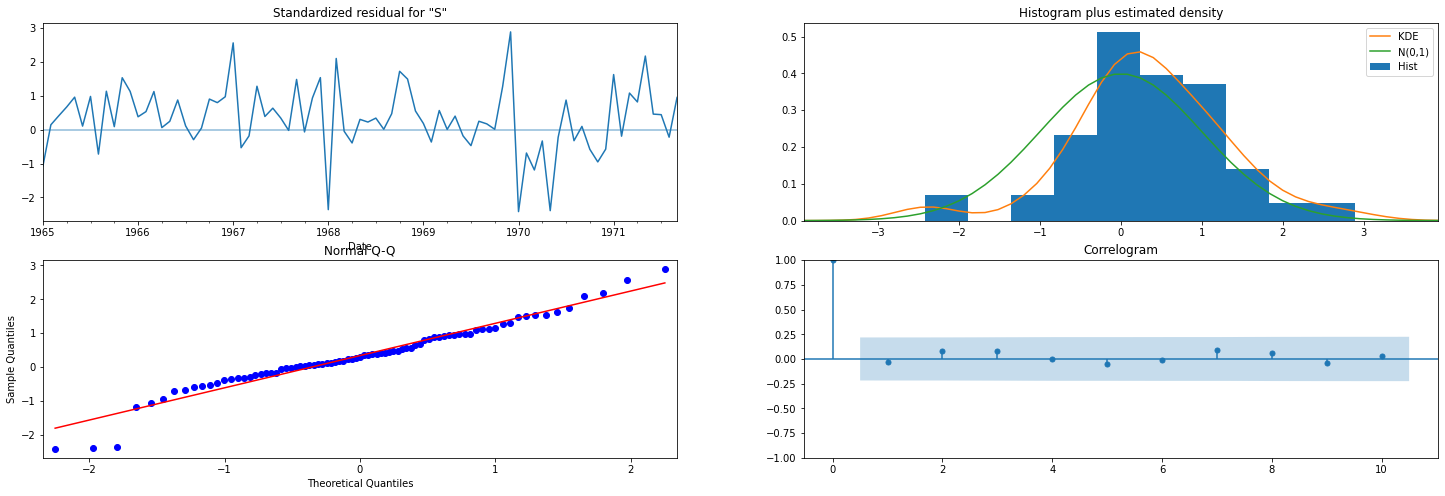

In [43]:
auto_model_2.plot_diagnostics(figsize=(25,8));

We can say that the residuals are distributed almost normally and there is no correlation between them.

Finally, we can plot the results and see how they look like.

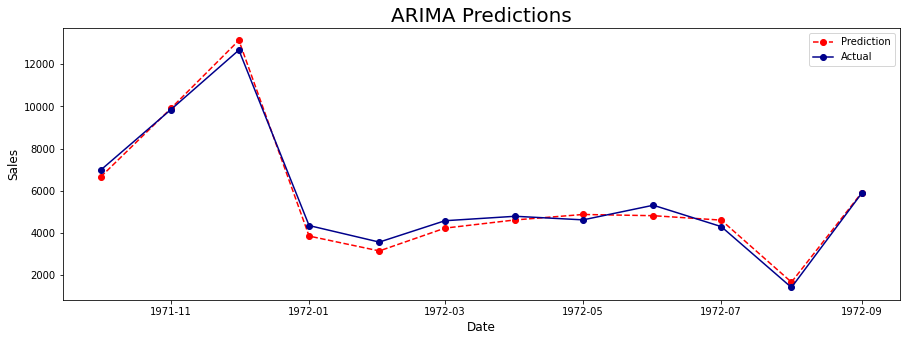

In [44]:
# Plotting the predictions
plt.figure(figsize=(15,5))
plt.plot(test.index, pred_ARIMA, label = "Prediction", linestyle = 'dashed', color = 'red',
        marker = 'o')
plt.plot(test.index, test['Sales'], label = "Actual", color = 'darkblue', marker= 'o')
plt.ylabel("Sales", size = 12)
plt.xlabel("Date", size = 12)
plt.legend()
plt.title("ARIMA Predictions", size = 20)
plt.show()

Everything looks fine!

# XGBoost Model

In [45]:
from xgboost import XGBRegressor

In [46]:
# Adding new columns
df['date']    = df.index
df['month']   = df['date'].dt.month
df['year']    = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter

In [47]:
# Test size
n = 12
# Splitting the data into train and test sets
train, test = df.iloc[:-n,:] , df.iloc[len(df)- n:,:]

In [48]:
# Independent variables
x_train  = train.loc[:, ["year", "month", "quarter"]]
x_test   = test.loc[:,  ["year", "month", "quarter"]]

In [49]:
# Dependent variables
y_test   = test["Sales"]
y_train  = train["Sales"]

In [50]:
reg = XGBRegressor()

In [51]:
reg.fit(x_train,
        y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds=25,
        eval_metric = 'rmse',
        verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [52]:
prediction_xgb = reg.predict(x_test)

In [53]:
# RMSE score
RMSE_xgb = np.sqrt(mean_squared_error(y_true=y_test,y_pred=prediction_xgb))
print('RMSE Score of XGBoost Model: ', RMSE_xgb)

RMSE Score of XGBoost Model:  309.11661623906815


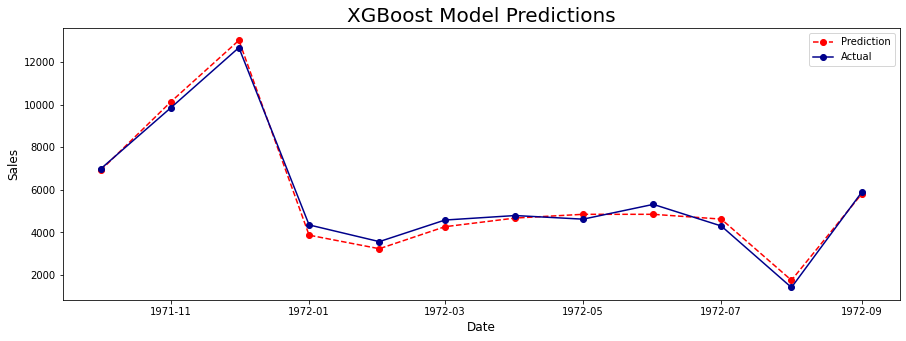

In [54]:
# Plotting the predictions
plt.figure(figsize=(15,5))
plt.plot(test.index, prediction_xgb, label = "Prediction", linestyle = 'dashed', color = 'red',
        marker = 'o')
plt.plot(test.index, test['Sales'], label = "Actual", color = 'darkblue', marker= 'o')
plt.ylabel("Sales", size = 12)
plt.xlabel("Date", size = 12)
plt.legend()
plt.title("XGBoost Model Predictions", size = 20)
plt.show()

In [55]:
from xgboost import plot_importance

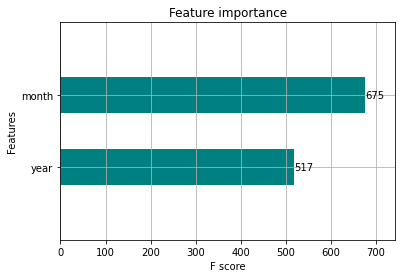

In [56]:
plot_importance(reg, height=.5, color = 'teal')
plt.show()

* Although we introduced the quarter of the year as a variable into the model, it is not on the feature importance plot so predictions do not depend on quarter.
* The seasonal characteristics of the data has more importance on the fit than the annual trend. 

### Prophet Model

In [57]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [58]:
model = Prophet( weekly_seasonality = False,
                 daily_seasonality = False )

In [59]:
df= data.copy()

In [60]:
df['Date'] = pd.to_datetime(df['Date']).dt.date
df.columns = ['ds', 'y']

In [61]:
# Splitting the data into test and train
n = 12
train_prophet = df.iloc[:-n,:]
future = df.iloc[len(df)- n:,:]
#y_test_prophet = train_prophet["y"]

In [62]:
train_prophet.head()

,ds,y
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [63]:
model.fit(train_prophet)

In [64]:
predict_model = model.predict(future)

In [65]:
predict_model.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1971-10-01,5808.771726,5415.639632,7316.975996,5808.766574,5808.793290,513.065274,513.065274,513.065274,513.065274,513.065274,513.065274,0.0,0.0,0.0,6321.837000
1,1971-11-01,5826.343384,8325.985412,10219.932744,5825.993811,5826.698754,3496.347962,3496.347962,3496.347962,3496.347962,3496.347962,3496.347962,0.0,0.0,0.0,9322.691346
2,1971-12-01,5843.348215,10932.556430,12876.672063,5842.559456,5844.232614,6003.564455,6003.564455,6003.564455,6003.564455,6003.564455,6003.564455,0.0,0.0,0.0,11846.912670
3,1972-01-01,5860.919874,3886.662157,5783.147169,5859.369611,5862.493938,-1086.162944,-1086.162944,-1086.162944,-1086.162944,-1086.162944,-1086.162944,0.0,0.0,0.0,4774.756930
4,1972-02-01,5878.491532,3444.021798,5316.453596,5876.209946,5880.927361,-1516.048073,-1516.048073,-1516.048073,-1516.048073,-1516.048073,-1516.048073,0.0,0.0,0.0,4362.443459


In [66]:
# Predictions
prediction_prophet = predict_model["yhat"]

In [67]:
# RMSE score
RMSE_prophet = np.sqrt(mean_squared_error(y_true=y_test,y_pred=prediction_prophet))

In [68]:
print(RMSE_prophet)

754.0793072729084


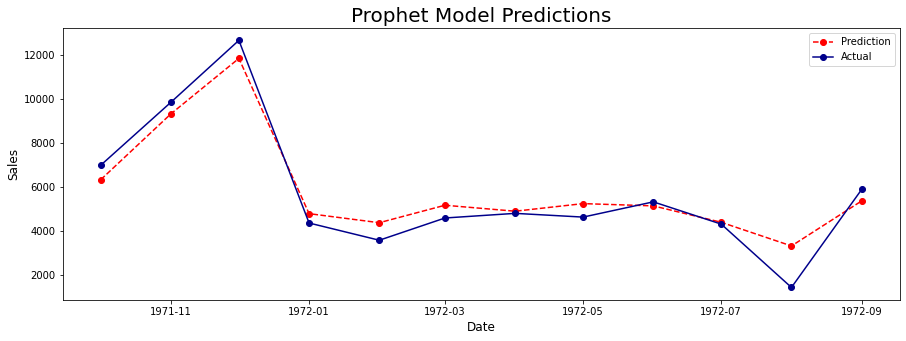

In [69]:
# Plotting the predictions
plt.figure(figsize=(15,5))
plt.plot(test.index, prediction_prophet, label = "Prediction", linestyle = 'dashed', color = 'red',
        marker = 'o')
plt.plot(test.index, test['Sales'], label = "Actual", color = 'darkblue', marker= 'o')
plt.ylabel("Sales", size = 12)
plt.xlabel("Date", size = 12)
plt.legend()
plt.title("Prophet Model Predictions", size = 20)
plt.show()

## Model Comparison

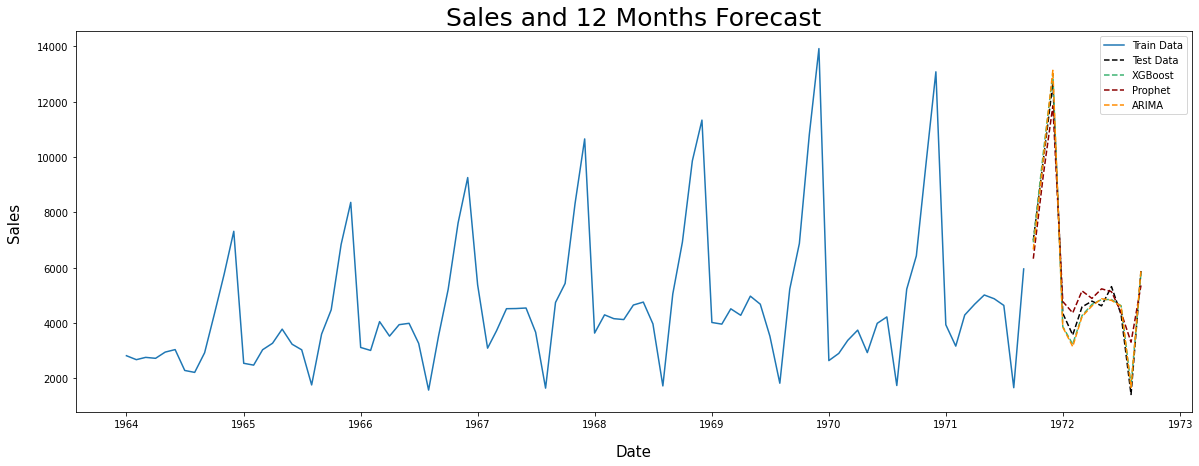

In [70]:
# Plot of the data and predictions
plt.figure(figsize= (20,7))
plt.plot(train.index, train["Sales"], label = 'Train Data')
plt.plot(test.index, test["Sales"], label = 'Test Data', linestyle = 'dashed', color = 'black')
plt.plot(test.index, prediction_xgb, label = 'XGBoost', linestyle = 'dashed', color = 'mediumseagreen')
plt.plot(test.index, prediction_prophet, label = 'Prophet', linestyle = 'dashed', color = 'darkred')
plt.plot(test.index, pred_ARIMA, label = 'ARIMA', linestyle='dashed', color = 'darkorange')
plt.xlabel("Date", fontsize=15,labelpad = 15)
plt.ylabel("Sales", fontsize=15, labelpad = 15)
plt.legend()
plt.title('Sales and 12 Months Forecast', size = 25)
plt.show()

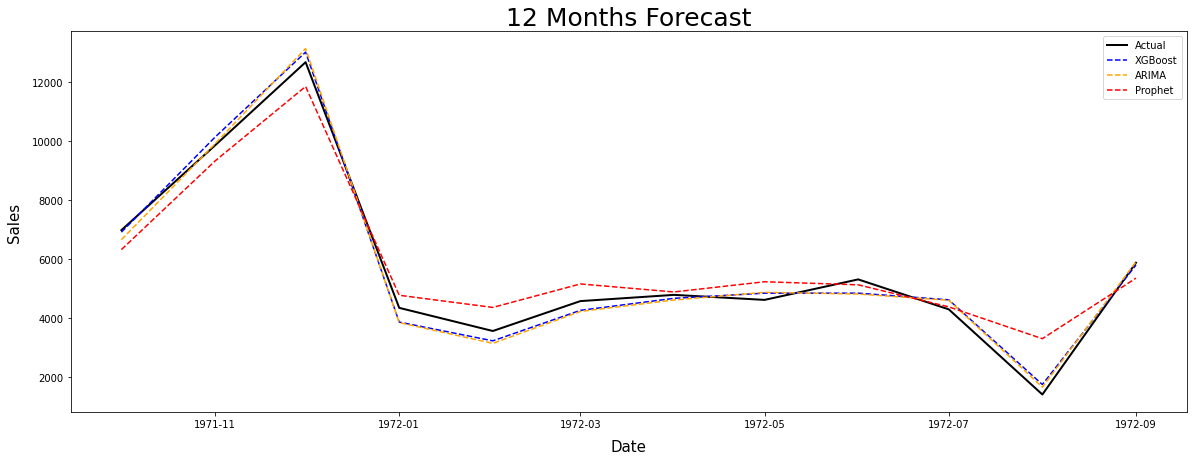

In [71]:
# Plot of the 12 months forecast and the test data
plt.figure(figsize= (20,7))
plt.plot(test.index, test["Sales"], label = 'Actual', color = 'black', linewidth=2)
plt.plot(test.index, prediction_xgb, label = 'XGBoost',  color = 'blue', linestyle = 'dashed')
plt.plot(test.index, pred_ARIMA, label = 'ARIMA', color = 'orange', linestyle = 'dashed')
plt.plot(test.index, prediction_prophet, label = 'Prophet', color = 'red', linestyle = 'dashed')

plt.xlabel("Date", fontsize=15,labelpad = 10)
plt.ylabel("Sales", fontsize=15, labelpad = 10)
plt.legend(loc='best')
plt.title('12 Months Forecast', fontsize=25)
plt.show()

In [72]:
RMSE = [RMSE_xgb, RMSE_ARIMA,RMSE_prophet,]
labels = [ 'XGBoost', 'ARIMA', 'Prophet']

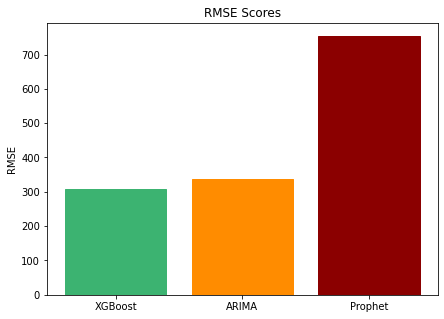

In [73]:
# Bar plot and af the RMSE Scores
fig = plt.figure(figsize=(7,5))
barPlot = plt.bar(labels,RMSE)
plt.ylabel('RMSE')
barPlot[0].set_color('mediumseagreen')
barPlot[1].set_color('darkorange')
barPlot[2].set_color('darkred')
plt.title('RMSE Scores')
plt.show()

In [74]:
print("Model       RMSE Score ")
print("---------   -----------------")
print("XGBoost :  ", RMSE_xgb)
print("ARIMA   :  ", RMSE_ARIMA)
print("Prophet :  ", RMSE_prophet)

Model       RMSE Score 
---------   -----------------
XGBoost :   309.11661623906815
ARIMA   :   337.5666495662602
Prophet :   754.0793072729084


* XGBoost has the lowest RMSE score among the models. 
* Prophet model does also make applicable predictions, however, both ARIMA and XGBoost models fit the data better. 